In [1]:
import os
from astropy.io import fits
import astropy.units as u

import jax
import jax.numpy as jnp
from jax import jit

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import scipy
from PIL import Image

from astropy.convolution import convolve
from astropy.convolution import Tophat2DKernel


In [2]:
def load_data(file_no):
    base_path = "/feynman/work/dap/lcs/vt272285/HOWLS/HOWLS_DATA/"
    fiducial = "SLICS_LCDM/"
    fiducial_path = base_path + fiducial + "kappa_noise_GalCatalog_LOS_cone" + str(file_no) + ".fits_s333" + str(file_no) + "_zmin0.0_zmax3.0_sys_3.fits_ks_nomask_shear.fits"
    full_file_path = fiducial_path
    try:
        with fits.open(full_file_path) as hdu:
            data = hdu[0].data
            data = data[0]
            angle_ =10 * u.deg
        return data, angle_
    except FileNotFoundError:
        print(f"File {full_file_path} not found.")
        return None
    
data, angle_ = load_data(file_no=75)


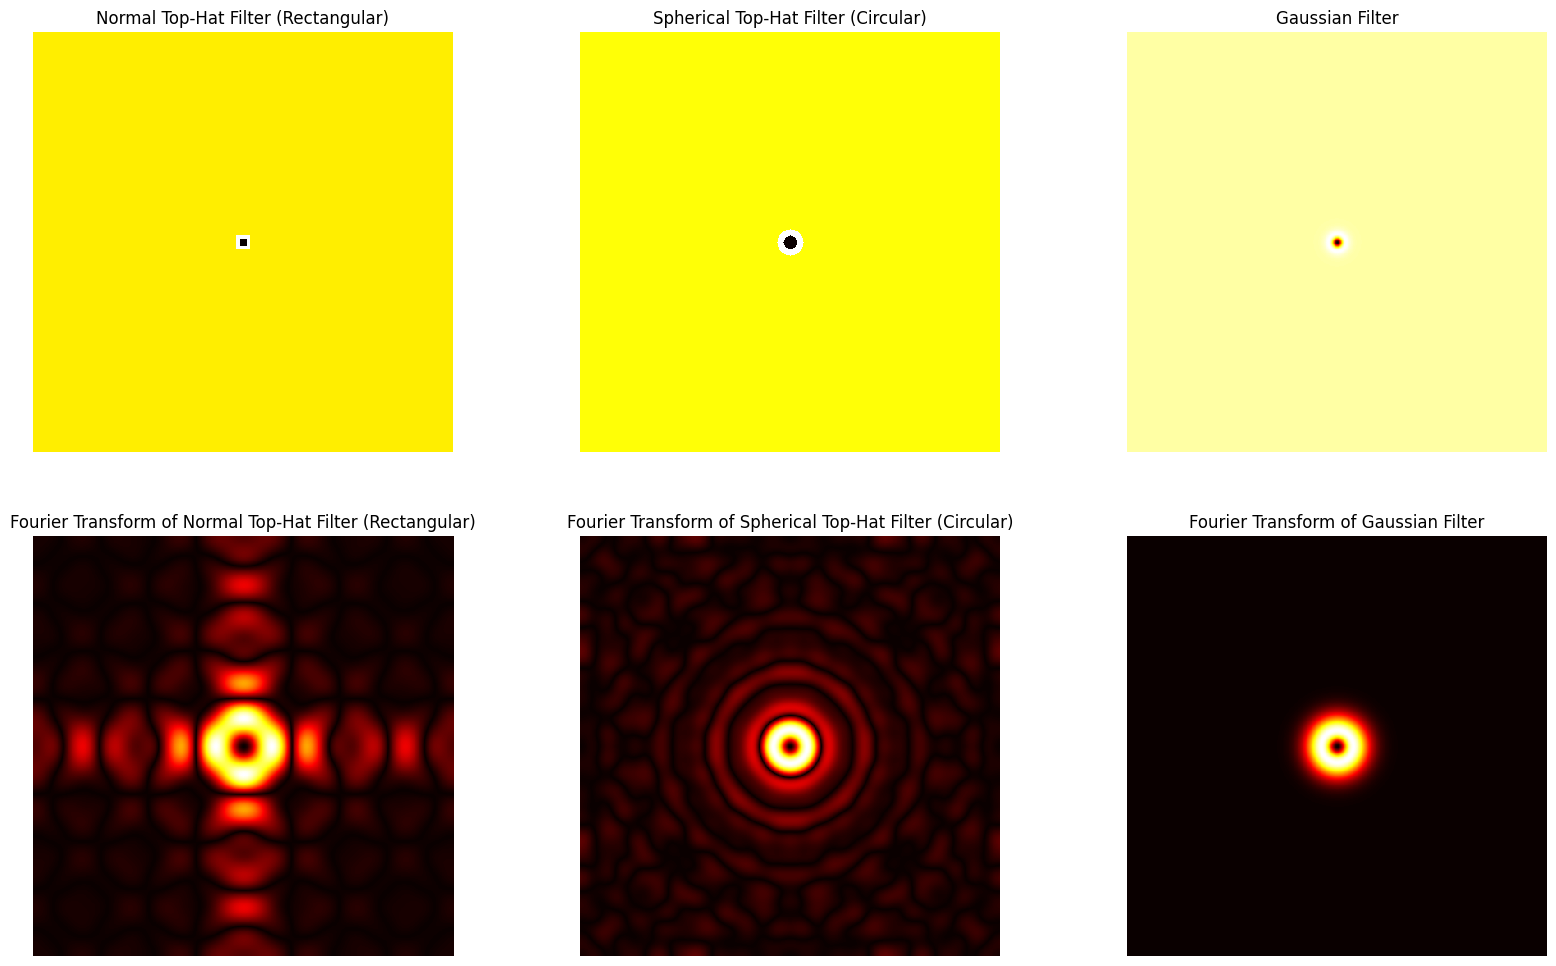

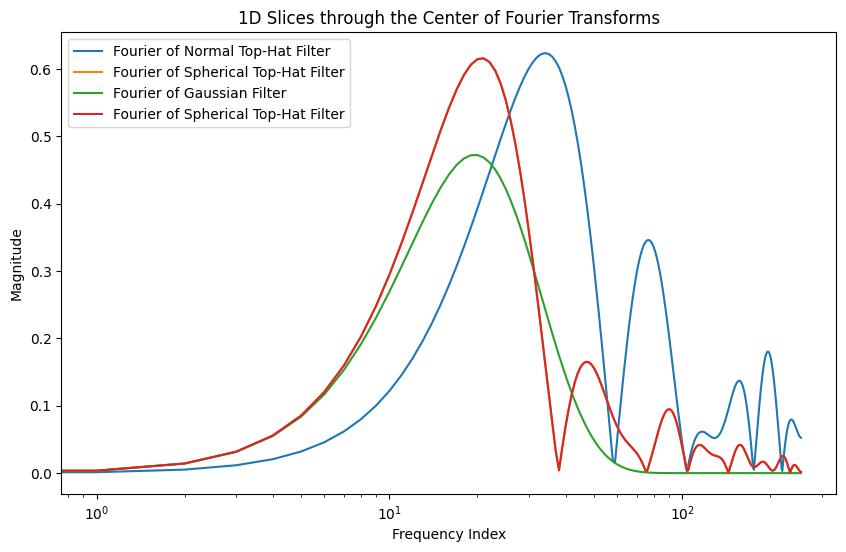

In [3]:
def normal_top_hat_filter(scale_exp, size):
    """
    Creates a 2D normal top-hat filter with given dyadic scale and size.
    """
    scale = 2 ** scale_exp
    filter_size = size // 2
    top_hat = np.zeros((size, size))
    for i in range(-scale, scale + 1):
        for j in range(-scale, scale + 1):
            if abs(i) <= scale and abs(j) <= scale:
                top_hat[filter_size + i, filter_size + j] = 1 / (4 * scale * scale)
                
    # Normalize the kernel so that it integrates to 1
    normalization_factor = np.sum(top_hat)
    top_hat /= normalization_factor
    
    return top_hat

def spherical_top_hat_filter(scale_exp, size):
    """
    Creates a 2D spherical top-hat filter with given dyadic scale and size.
    """
    scale = 2 ** scale_exp
    filter_size = size // 2
    top_hat = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            r = np.sqrt((i - filter_size) ** 2 + (j - filter_size) ** 2)
            if r <= 2 * scale:
                top_hat[i, j] = 1 / (np.pi * (2 * scale) ** 2)
                
    # Normalize the kernel so that it integrates to 1
    normalization_factor = np.sum(top_hat)
    top_hat /= normalization_factor
    
    return top_hat

def gaussian_filter(scale_exp, size):
    """
    Creates a 2D Gaussian filter with a given dyadic scale and size.
    
    Parameters:
    scale_exp (int): The exponent to determine the scale of the filter.
    size (int): The size of the filter (should be an odd number).
    
    Returns:
    np.ndarray: The 2D Gaussian filter.
    """
    scale = 2 ** scale_exp
    filter_size = size // 2
    gaussian = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            x = i - filter_size
            y = j - filter_size
            gaussian[i, j] = np.exp(-(x ** 2 + y ** 2) / (2 * scale ** 2))
    
    # Normalize the kernel so that it integrates to 1
    normalization_factor = np.sum(gaussian)
    gaussian /= normalization_factor
    
    return gaussian

def fourier_transform(filter_2d):
    """
    Computes the Fourier transform of a 2D filter and shifts the zero frequency component to the center.
    """
    f_transform = np.fft.fft2(filter_2d)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shifted)
    return magnitude_spectrum

# Parameters
scale_exp = 3  # Example dyadic scale: 2^3 = 8
size = 512  # Ensuring size is sufficiently large

# Generate filters
normal_top_hat = normal_top_hat_filter(scale_exp, size) - normal_top_hat_filter(scale_exp-1, size)
spherical_top_hat = spherical_top_hat_filter(scale_exp, size) - spherical_top_hat_filter(scale_exp-1, size)
gaussian = gaussian_filter(scale_exp, size) - gaussian_filter(scale_exp-1, size)

# Compute Fourier transforms
fourier_normal_top_hat = fourier_transform(normal_top_hat)
fourier_spherical_top_hat = fourier_transform(spherical_top_hat)
fourier_gaussian = fourier_transform(gaussian)

# Plot filters and their Fourier transforms
fig, ax = plt.subplots(2, 3, figsize=(20, 12))

ax[0, 0].imshow(normal_top_hat, cmap='hot', interpolation='nearest')
ax[0, 0].set_title('Normal Top-Hat Filter (Rectangular)')
ax[0, 0].axis('off')

ax[0, 1].imshow(spherical_top_hat, cmap='hot', interpolation='nearest')
ax[0, 1].set_title('Spherical Top-Hat Filter (Circular)')
ax[0, 1].axis('off')

ax[0, 2].imshow(gaussian, cmap='hot', interpolation='nearest')
ax[0, 2].set_title('Gaussian Filter')
ax[0, 2].axis('off')

ax[1, 0].imshow(np.log(1 + fourier_normal_top_hat), cmap='hot', interpolation='nearest')
ax[1, 0].set_title('Fourier Transform of Normal Top-Hat Filter (Rectangular)')
ax[1, 0].axis('off')

ax[1, 1].imshow(np.log(1 + fourier_spherical_top_hat), cmap='hot', interpolation='nearest')
ax[1, 1].set_title('Fourier Transform of Spherical Top-Hat Filter (Circular)')
ax[1, 1].axis('off')

ax[1, 2].imshow(np.log(1 + fourier_gaussian), cmap='hot', interpolation='nearest')
ax[1, 2].set_title('Fourier Transform of Gaussian Filter')
ax[1, 2].axis('off')

plt.show()

def plot_1d_slices(fourier_filter, title):
    """
    Plots the 1D slice through the center of the Fourier transform.
    """
    center = fourier_filter.shape[0] // 2
    slice_1d = fourier_filter[center, :]
    plt.plot(slice_1d[len(slice_1d)//2 :], label=title)
    return

# Plot 1D slices
plt.figure(figsize=(10, 6))
plot_1d_slices(fourier_normal_top_hat, 'Fourier of Normal Top-Hat Filter')
plot_1d_slices(fourier_spherical_top_hat, 'Fourier of Spherical Top-Hat Filter')
plot_1d_slices(fourier_gaussian, 'Fourier of Gaussian Filter')
plot_1d_slices(fourier_spherical_top_hat, 'Fourier of Spherical Top-Hat Filter')
plt.xscale("log")
plt.title('1D Slices through the Center of Fourier Transforms')
plt.xlabel('Frequency Index')
plt.ylabel('Magnitude')
plt.legend()
plt.show()



In [4]:
def apply_filter(image, filter_2d):
    """
    Applies a 2D filter to an image using convolution with proper FFT shift.
    """
    # Perform FFT on both the image and the filter, and shift the zero-frequency component to the center
    fft_image = np.fft.fftshift(np.fft.fft2(image))
    fft_filter = np.fft.fftshift(np.fft.fft2(filter_2d, s=image.shape))
    
    # Multiply the FFTs and shift back
    fft_result = fft_image * fft_filter
    ifft_result = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(fft_result)))
    
    return ifft_result.real
    # return convolve(image, filter_2d)

def wavelet_decomposition(image, filter_type, max_scale_exp):
    """
    Performs wavelet decomposition on the input image using the specified filter type.
    """
    size = image.shape[0]
    c0 = image
    c = c0
    wavelet_coeffs = []

    for i in range(1, max_scale_exp + 1):
        if filter_type == 'normal':
            filter_2d = normal_top_hat_filter(i, size)
            T_c0 = apply_filter(c0, filter_2d)
            w = c - T_c0
            wavelet_coeffs.append(w)
            c = T_c0
        elif filter_type == 'spherical':
            filter_2d = spherical_top_hat_filter(i, size)
            T_c0 = apply_filter(c0, filter_2d)
            w = c - T_c0
            wavelet_coeffs.append(w)
            c = T_c0
        elif filter_type == 'gaussian':
            filter_2d = gaussian_filter(i, size)
            T_c0 = apply_filter(c0, filter_2d)
            w = c - T_c0
            wavelet_coeffs.append(w)
            c = T_c0
        elif filter_type == "tophat":
            kernel = Tophat2DKernel(2**i)
            T_c0 = convolve(image, kernel)
            w = c - T_c0
            wavelet_coeffs.append(w)
            c = T_c0
        else:
            raise ValueError("Unknown filter type. Use 'normal' or 'spherical'.")
    return wavelet_coeffs, c

def wavelet_reconstruction(wavelet_coeffs, c_final):
    """
    Reconstructs the original image from wavelet coefficients and the final smoothed image.
    """
    c0_reconstructed = np.sum(wavelet_coeffs, axis=0) + c_final
    # for w in wavelet_coeffs:
    #     c0_reconstructed += w
    return c0_reconstructed

def visualize_wavelet_decomposition(image, max_scale_exp, filter_type):
    wavelet_coeffs_spherical, c_final_spherical = wavelet_decomposition(image, filter_type, max_scale_exp)
    reconstructed_image_spherical = wavelet_reconstruction(wavelet_coeffs_spherical, c_final_spherical)

    plt.figure(figsize=(16, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.imshow(image - reconstructed_image_spherical)
    plt.colorbar()
    plt.title("Difference Spherical Top Hat")
     
    plt.subplot(1, 3, 3)
    plt.title("Reconstructed (Spherical)")
    plt.imshow(reconstructed_image_spherical)
    plt.colorbar()
    plt.tight_layout()
    plt.show()  
    return


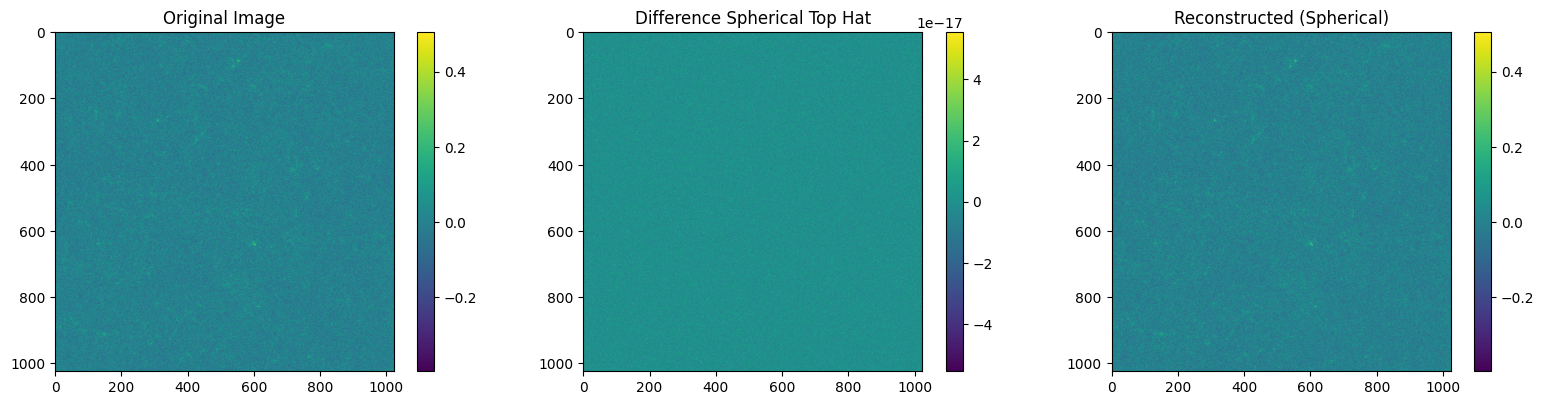

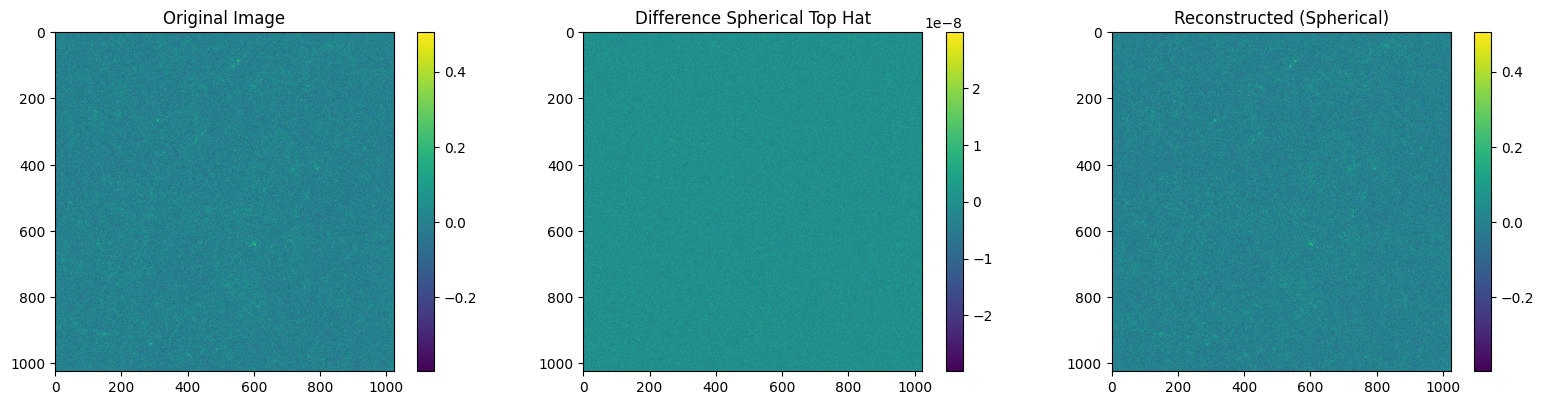

In [5]:
max_scale_exp = 3  # Change this value as needed
size = 50
dirac_image = np.zeros((size, size))

# Set the center pixel to a high value
center = size // 2
dirac_image[center, center] = 10

dog_image = Image.open("dog_image.jpeg")

# Convert the image to grayscale
dog_gray = dog_image.convert('L')
dog_array = np.array(dog_gray)


visualize_wavelet_decomposition(data, max_scale_exp,"spherical")
visualize_wavelet_decomposition(data, max_scale_exp,"tophat")
# visualize_wavelet_decomposition(data, max_scale_exp,"gaussian")

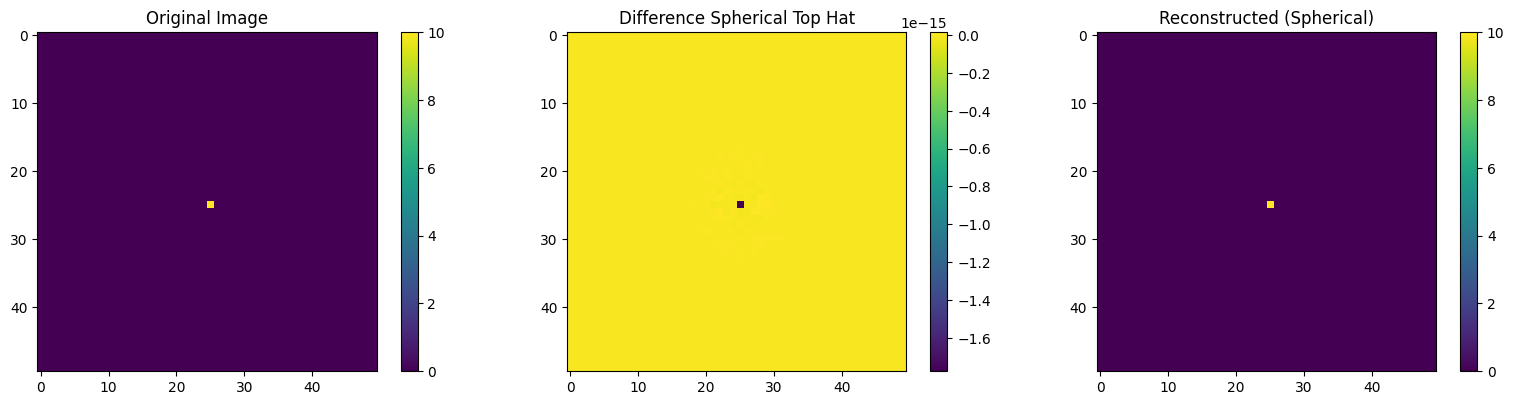

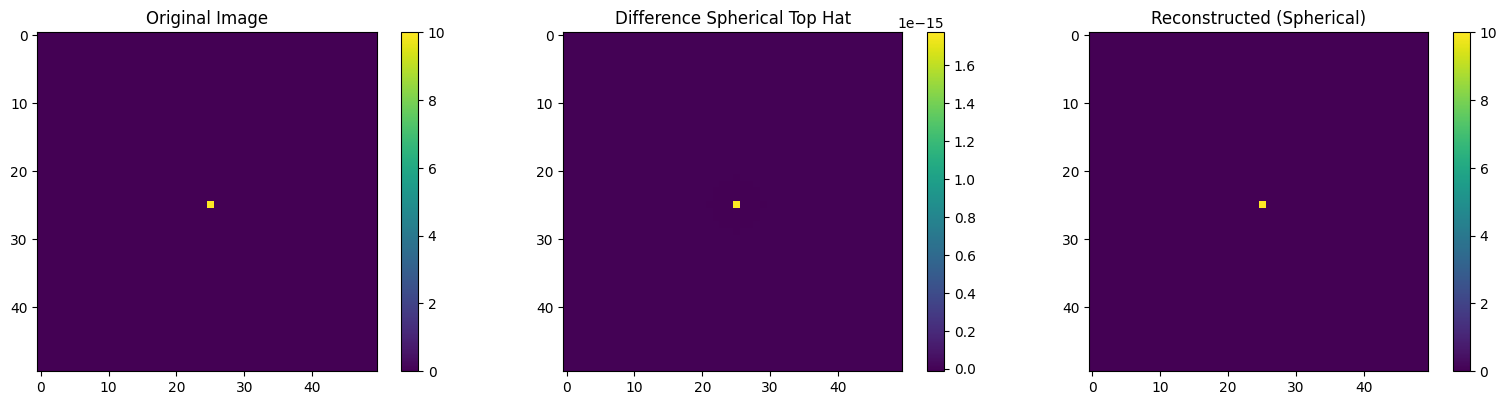

In [6]:
visualize_wavelet_decomposition(dirac_image, max_scale_exp,"spherical")
visualize_wavelet_decomposition(dirac_image, max_scale_exp,"tophat")

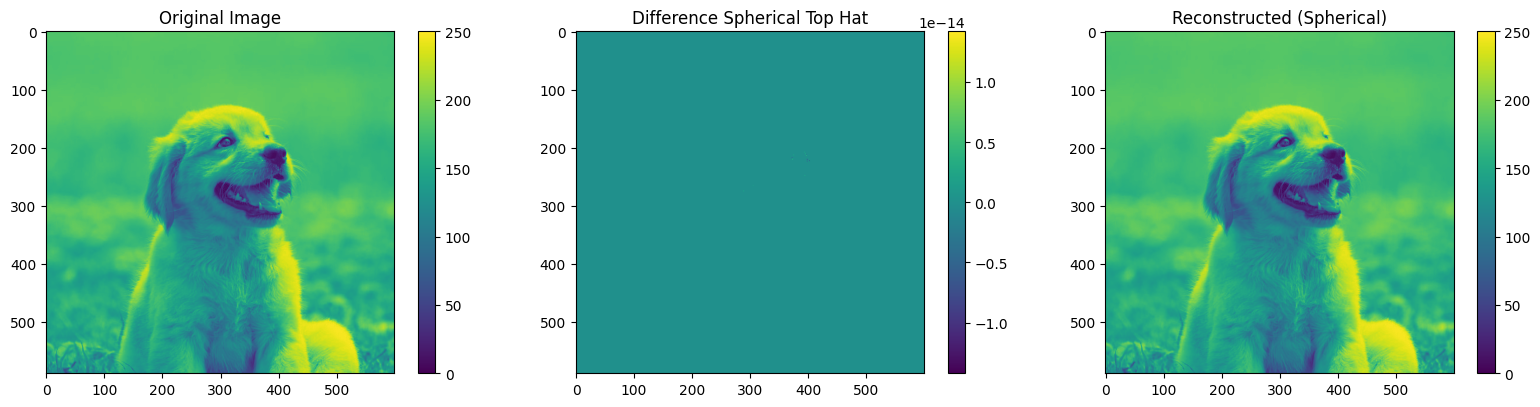

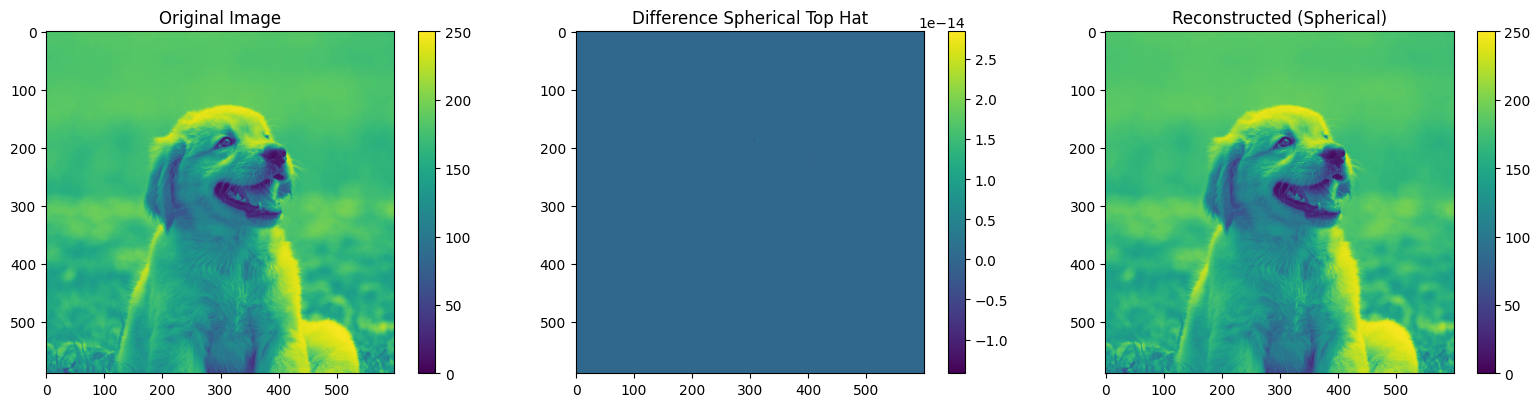

In [7]:
visualize_wavelet_decomposition(dog_array, max_scale_exp,"spherical")
visualize_wavelet_decomposition(dog_array, max_scale_exp,"tophat")

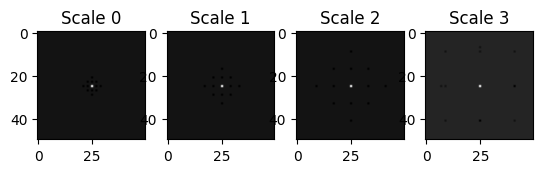

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

def spherical_top_hat_filter(scale_exp, size):
    """
    Creates a 2D spherical top-hat filter with given dyadic scale and size.
    """
    scale = 2 ** scale_exp
    filter_size = size // 2
    top_hat = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            r = np.sqrt((i - filter_size) ** 2 + (j - filter_size) ** 2)
            if r <= 2 * scale:
                top_hat[i, j] = 1 / (np.pi * (2 * scale) ** 2)
                
    # Normalize the kernel so that it integrates to 1
    normalization_factor = np.sum(top_hat)
    top_hat /= normalization_factor
    
    return top_hat

def insert_zeros(filter, step):
    size = filter.shape[0]
    new_size = size + (size - 1) * (step - 1)
    new_filter = np.zeros((new_size, new_size))
    for i in range(size):
        for j in range(size):
            new_filter[i * step, j * step] = filter[i, j]
    return new_filter

def a_trous_transform(image, num_scales, filter_size):
    original_filter = spherical_top_hat_filter(0, filter_size)
    current_image = image.copy()
    residuals = []
    
    for scale in range(1,num_scales+1):
        step = 2 ** scale
        filter_with_zeros = insert_zeros(original_filter, step)
        smoothed = convolve(current_image, filter_with_zeros, mode='mirror')
        residuals.append(current_image - smoothed)
        # current_image = smoothed
    
    return residuals, smoothed

# Example usage:
image = dirac_image  # Replace with your input image
num_scales = 4
filter_size = 15

wavelet_coeffs, final_residual = a_trous_transform(image, num_scales, filter_size)

# Visualization of wavelet coefficients
for i, coeff in enumerate(wavelet_coeffs):
    plt.subplot(1, num_scales, i+1)
    plt.imshow(coeff, cmap='gray')
    plt.title(f'Scale {i}')
plt.show()


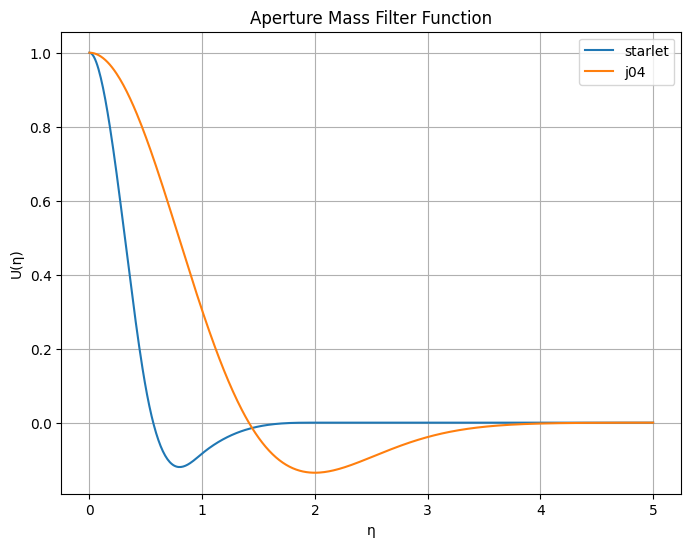

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def j04(vartheta, theta):
    """
    Compute the aperture mass filter function U_theta(vartheta).
    
    Parameters:
    vartheta (float or np.ndarray): Radial distance from the center of the aperture.
    theta (float): Scale parameter that determines the size of the aperture.
    
    Returns:
    float or np.ndarray: Value of the aperture mass filter function.
    """
    coefficient = 1 / (2 * np.pi * theta ** 2)
    term = 1 - (vartheta ** 2 / (2 * theta ** 2))
    exponential = np.exp(-vartheta ** 2 / (2 * theta ** 2))
    return coefficient * term * exponential

def starlet_filter(vartheta, theta):
    """
    Compute the aperture mass filter function U(eta).
    
    Parameters:
    vartheta (float or np.ndarray): Radial distance from the center of the aperture.
    theta (float): Scale parameter that determines the size of the aperture.
    
    
    Returns:
    float or np.ndarray: Value of the aperture mass filter function.
    """
    eta = vartheta/theta
    term1 = 93 * np.abs(eta)**3
    term2 = 64 * ( (np.abs(0.5 - eta)**3) + (np.abs(0.5 + eta)**3) )
    term3 = 18 * (np.abs(1 - eta)**3 + np.abs(1 + eta)**3)
    term4 = 0.5 * (np.abs(2 - eta)**3 + np.abs(2 + eta)**3)
    
    return (1/9) * (term1 - term2 + term3 - term4)

# Example usage
theta = 2.0
vartheta_values = np.linspace(0, 10, 500)

j04_filter_values = j04(vartheta_values, theta)

eta_values = vartheta_values / theta
starlet_filter_values = starlet_filter(vartheta_values, theta)

# Plotting the filter function
plt.figure(figsize=(8, 6))
plt.plot(vartheta_values/theta, starlet_filter_values/np.max(starlet_filter_values), label="starlet")
plt.xlabel('η')
plt.ylabel('U(η)')
plt.title('Aperture Mass Filter Function')


plt.plot(vartheta_values/theta, j04_filter_values/np.max(j04_filter_values), label="j04")
plt.legend()
plt.grid(True)
plt.show()


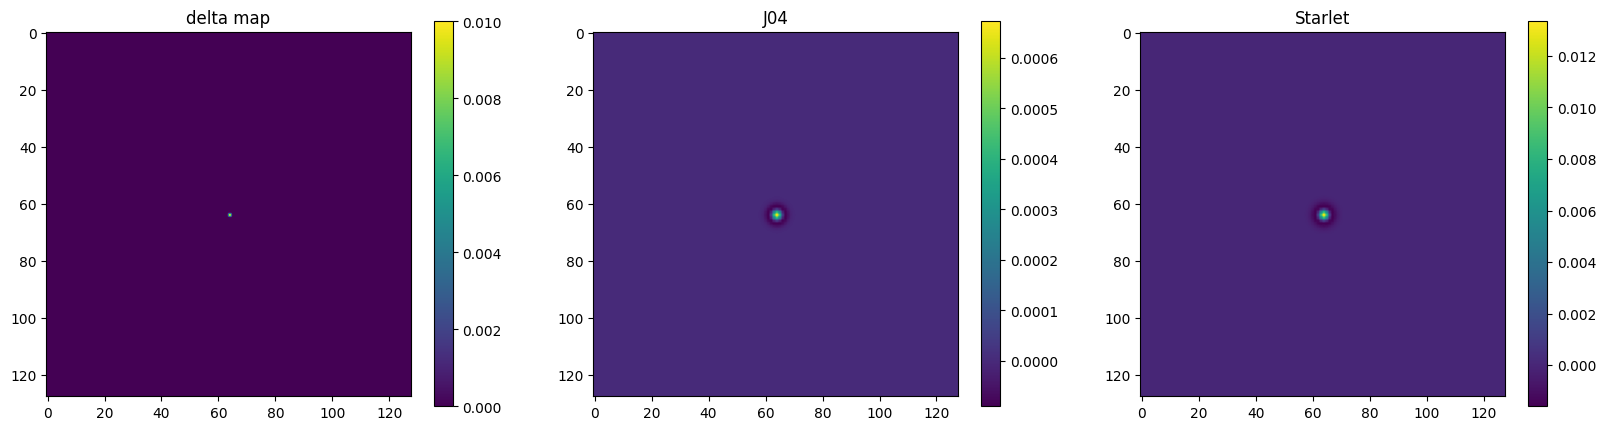

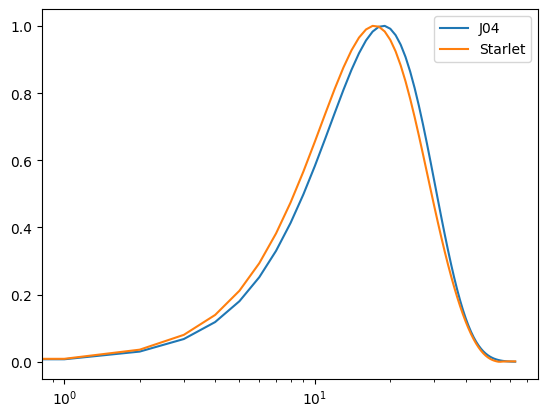

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

# Step 1: Generate the artificial shear data
size = 128  # size of the grid
delta_map = np.zeros((size, size))
delta_map[size//2, size//2] = 1e-2  # central delta function

# Step 2: Define the aperture mass algorithm
def aperture_mass(map, theta, filter_func, truncation_radius=None):
    y, x = np.indices(map.shape)
    center = np.array([size//2, size//2])
    vartheta = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    
    if truncation_radius is not None:
        mask = vartheta <= truncation_radius
        vartheta = vartheta * mask
    
    filter_values = filter_func(vartheta, theta)
    aperture_mass_map = convolve(map, filter_values) 
    return aperture_mass_map

# Step 4: Apply the aperture mass algorithm
theta = 4.0
j04_mass_theta = aperture_mass(delta_map, theta/2.6, j04)
starlet_mass = aperture_mass(delta_map, theta, starlet_filter)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.title("delta map")
plt.imshow(delta_map)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("J04")
plt.imshow(j04_mass_theta)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("Starlet")
plt.imshow(starlet_mass)
plt.colorbar()
plt.show()


def fourier_transform(filter_2d):
    """
    Computes the Fourier transform of a 2D filter and shifts the zero frequency component to the center.
    """
    f_transform = np.fft.fft2(filter_2d)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shifted)
    return magnitude_spectrum


def plot_1d_slices(fourier_filter, title):
    """
    Plots the 1D slice through the center of the Fourier transform.
    """
    center = fourier_filter.shape[0] // 2
    slice_1d = fourier_filter[center, :]
    plt.plot(slice_1d[len(slice_1d)//2 :]/np.max(slice_1d[len(slice_1d)//2 :]), label=title)
    return

plot_1d_slices(fourier_transform(j04_mass_theta), "J04")
plot_1d_slices(fourier_transform(starlet_mass), "Starlet")
plt.xscale("log")
plt.legend()
